### 使用$（r ，\theta ）$的坐标训练神经ODE
question1: 如何固定一个二阶的微分方程网络模型？

In [5]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchdiffeq import odeint  # 神经ODE库

#导入数据,数据预处理
df = pd.read_csv('./earth_r_o_orbit.csv')
array = df.to_numpy()
array = array.T
t = array[0]/(24*60*60)                 #以天为单位，86400秒
y1 = array[1]/1e10                      #距离为1e10m
y2 = array[2] * 86400 / 1e10            #速度：10亿米/天
y3 = array[3]                           #弧度无量纲，暂不更改
y4 = array[4]*86400                     #rad/天
y = np.vstack([y1, y2, y3,y4])
print(y.shape)





# 将数据转换为张量格式
coords = torch.tensor(y.T, dtype=torch.float32)
t_tensor = torch.tensor(t,dtype=torch.float32)

print(coords.shape)
print(coords[0])

# 2. 定义ODE模型
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 16),
            nn.Tanh(),
            nn.Linear(16, 20)  
        )
        self.fc1 = nn.Linear(20,2)

    def forward(self,t, y):
        y2 = self.net(y)
        y2= torch.sin(y2)
        y2 = self.fc1(y2)
        return torch.cat([y[1].unsqueeze(0), y2[0].unsqueeze(0), y[3].unsqueeze(0), y2[1].unsqueeze(0)])
    
'''#测试前馈效果，确保满足二阶微分方程关系。
ode_func = ODEFunc()
y0 = coords[0]
print(ode_func.forward(t,y0))'''


#早停用函数
def errors(data):
    mean_value = np.mean(data)
    errors = data - mean_value
    absolute_errors = np.abs(errors)
    mae = np.mean(absolute_errors)
    return mae

# 初始化ODE函数和模型
ode_func = ODEFunc()
optimizer = optim.Adam(ode_func.parameters(), lr=0.01)
criterion = nn.MSELoss()

# 设置超参数
epochs = 2000
loss_value = []
mini_delta = 0.005
sum_ = np.array([0,0,0,0,0])

#3. 模型训练
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # 神经ODE求解
    pred_y = odeint(ode_func, coords[0], t_tensor)
    
    # 计算损失
    loss = criterion(pred_y, coords)
    
    # 反向传播和优化
    loss.backward()
    optimizer.step()
    
    # 打印损失
    if epoch % 200 == 0:
        print(f"Epoch {epoch+200}, Loss: {loss.item()}")

    #设置早停
    loss_value.append(loss.item())
    if epoch > 5:
        for i in range(5):
            sum_[i] = loss_value[epoch]-loss_value[epoch-i-1]
    err = errors(sum_)

    if loss.item() < 0.0001 and err < 0.00001 :
        break


(4, 8760)
torch.Size([8760, 4])
tensor([14.7100,  0.0000,  0.0000,  0.0178])
Epoch 200, Loss: 885556736.0
Epoch 400, Loss: 123.3770980834961
Epoch 600, Loss: 115.3676528930664
Epoch 800, Loss: 109.3594741821289
Epoch 1000, Loss: 107.48041534423828


KeyboardInterrupt: 

### 将训练结果可视化，检测实际效果，与实际数据对比

[[ 1.47100000e+01  1.47100003e+01  1.47100011e+01 ...  1.47100102e+01
   1.47100072e+01  1.47100047e+01]
 [ 0.00000000e+00  6.35446674e-06  1.27089191e-05 ... -3.94573115e-05
  -3.31030786e-05 -2.67487705e-05]
 [ 0.00000000e+00  1.48275252e-03  2.96550494e-03 ...  1.25571635e+01
   1.25586462e+01  1.25601290e+01]
 [ 1.77909993e-02  1.77909987e-02  1.77909968e-02 ...  1.77909746e-02
   1.77909819e-02  1.77909879e-02]]
(8760, 4)


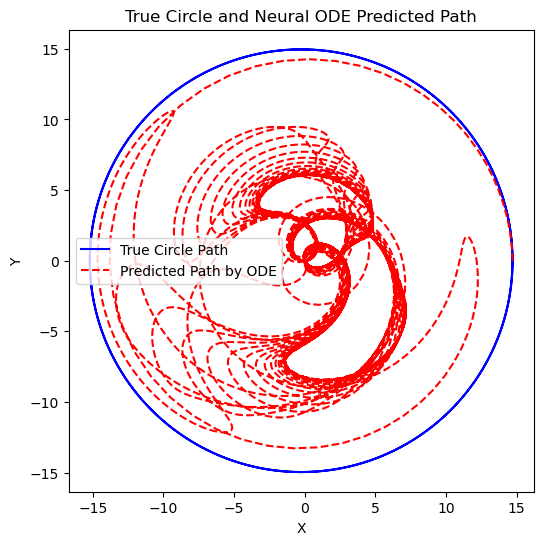

In [7]:
# 4. 可视化结果
with torch.no_grad():
    pred_y = odeint(ode_func, coords[0], t_tensor)
    pred_y = pred_y.numpy()


# 绘制真实轨迹和预测轨迹
print(y)
r1 = y[0]
theta1 = y[2]

# 将极坐标转换为笛卡尔坐标，便于绘图
x1 = r1 * np.cos(theta1)
y1 = r1 * np.sin(theta1)

print(pred_y.shape)
pred_y = pred_y.T
rr = pred_y[0]
oo = pred_y[2]
x = rr * np.cos(oo)
y = rr * np.sin(oo)


plt.figure(figsize=(6, 6))
plt.plot(x1, y1, 'b-', label="True Circle Path")
plt.plot(x, y, 'r--', label="Predicted Path by ODE")
plt.xlabel('X')
plt.ylabel('Y')
plt.title('True Circle and Neural ODE Predicted Path')
plt.axis('equal')
plt.legend()
plt.show()


C:\Users\19464\AppData\Local\Temp\ipykernel_372\1590143608.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('ode_orbit_model_weigh

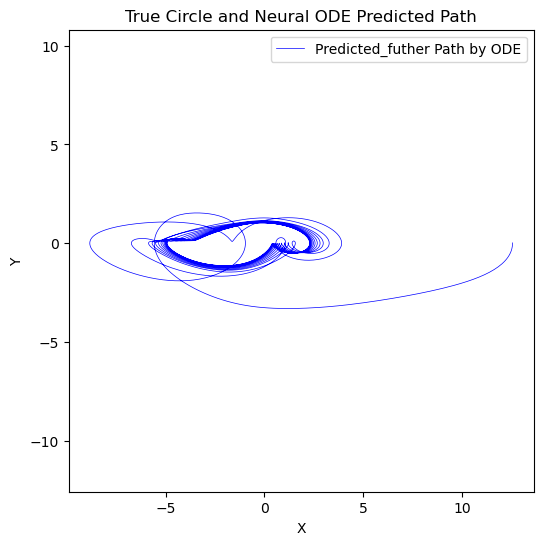

In [8]:
torch.save(ode_func.state_dict(), 'ode_orbit_model_weights.pth')

# 加载模型的状态字典
loaded_model = ODEFunc()
loaded_model.load_state_dict(torch.load('ode_orbit_model_weights.pth'))
loaded_model.eval()

# 新输入数据预测
time = torch.linspace(0,500,500*12)
with torch.no_grad():
    pred_y2 = odeint(ode_func, coords[-1], time)
    pred_y2 = pred_y2.numpy()

plt.figure(figsize=(6, 6))
plt.plot(pred_y2[:, 2], pred_y2[:, 3], 'b-', label="Predicted_futher Path by ODE", linewidth = 0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('True Circle and Neural ODE Predicted Path')
plt.axis('equal')
plt.legend()
plt.show()
